In this notebook we explain how do we implement the Displaced Diffusion model, here are the steps

1. Retrieve market implied volatility
2. Find sigma and beta so that volatility difference is minimized
3. Use sigma and beta from #2 to calculate dd pricing
4. Retrieve impl vol for dd pricing results
5. Plot implied vols for market and DD

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

In [27]:
#disp diffusion
def displaced_diffusion_call(S,K,r,sigma,T,beta):
    '''
    Returns price of a call option using the displaced diffusion method
    
        Parameters:
            S       : Underlying asset (i.e. Stock) price
            K       : Strike price
            r       : risk free rate (in decimals, not percentage, usually per annum)
            sigma   : volatility
            T       : time period (usually per annum)
            beta    : displace diffusion parameter
        
        Returns :
            call option price
    '''
    #params seem shared for call and put, possible to create
    F = S * np.exp(r*T)
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + (( 1.0 - beta )* F / beta) 

    d1 = (np.log(F_b / K_b) + (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    d2 = (np.log(F_b / K_b) - (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    return np.exp(-r * T) * (F_b * norm.cdf(d1) - K_b * norm.cdf(d2))

def displaced_diffusion_put(S,K,r,sigma,T,beta):
    '''
    Returns price of a put option using the displaced diffusion method
    
        Parameters:
            S       : Underlying asset (i.e. Stock) price
            K       : Strike price
            r       : risk free rate (in decimals, not percentage, usually per annum)
            sigma   : volatility
            T       : time period (usually per annum)
            beta    : displace diffusion parameter
        
        Returns :
            put option price
    '''
    F = S * np.exp(r*T)
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + (( 1.0 - beta )* F / beta) 
    d1 = (np.log(F_b / K_b) + (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    d2 = (np.log(F_b / K_b) - (0.5 * (sigma_b ** 2) * T)) / (sigma_b * np.sqrt(T))
    return np.exp(-r * T) * (K_b * norm.cdf(-d2) - F_b * norm.cdf(-d1))

In [28]:
#implied volatility reporting
def implied_volatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            #print('call impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_call(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            #print('put impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_put(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception as e:
        #print(e)
        impliedVol = np.nan

    return impliedVol

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_put(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [29]:
#Read SPX data
filename = 'SPX_options'
df = pd.read_csv(f'{filename}.csv')
df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['exdate'] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['years_to_expiry'] = df['days_to_expiry']/365
#setup rates calculator
rates_df = pd.read_csv('zero_rates_20201201.csv')
rate_interpolate = interp1d(rates_df['days'], rates_df['rate'])
df['rates'] = rate_interpolate(df['days_to_expiry']) / 100.0 #make it in fractions so i dont forget

try:
    if filename.lower() == 'spy_options':
        S = 366.02
    elif filename.lower() == 'spx_options':
        S = 3662.45
    else:
        raise NameError('unknown input file')
except Exception as e:
    print(e)

#impl market volatility column
df['vols'] = df.apply(lambda x: implied_volatility(S, x['strike'], x['rates'], x['mid'], x['years_to_expiry'], x['payoff']),axis=1)
df.dropna(inplace=True)



In [30]:
#create market DF for each timestamp
days_to_expiry  = sorted(df['days_to_expiry'].unique())
summary_df = pd.DataFrame({'strike': df['strike'].unique() })
for days in days_to_expiry:
    day_df  = df[df['days_to_expiry'] == days]
    call_df = day_df[day_df['payoff'] == 'call']
    put_df  = day_df[day_df['payoff'] == 'put']
    strikes = sorted(day_df['strike'].unique())
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    day_market_df = pd.DataFrame({'strike': strikes, days : impliedvols})
    summary_df = pd.merge(summary_df, day_market_df, how="outer", on='strike')
summary_df = summary_df.sort_values(by=['strike'])
summary_df = summary_df.reset_index()
summary_df = summary_df.drop(columns=['index'])
summary_df.to_csv(f'{filename}_vol_summary.csv')
summary_df


,strike,17,45,80
0,100.0,4.685324,3.020479,2.160100
1,200.0,3.741195,2.408988,1.724868
2,300.0,3.204791,2.062602,1.477592
3,400.0,2.830325,1.821174,1.304969
4,500.0,2.542973,1.636102,1.172504
...,...,...,...,...
406,5000.0,0.436196,0.276282,0.224559
407,5100.0,0.461523,0.292255,0.234641
408,5200.0,0.486234,0.307836,0.243829
409,5300.0,0.486495,0.323046,0.255771


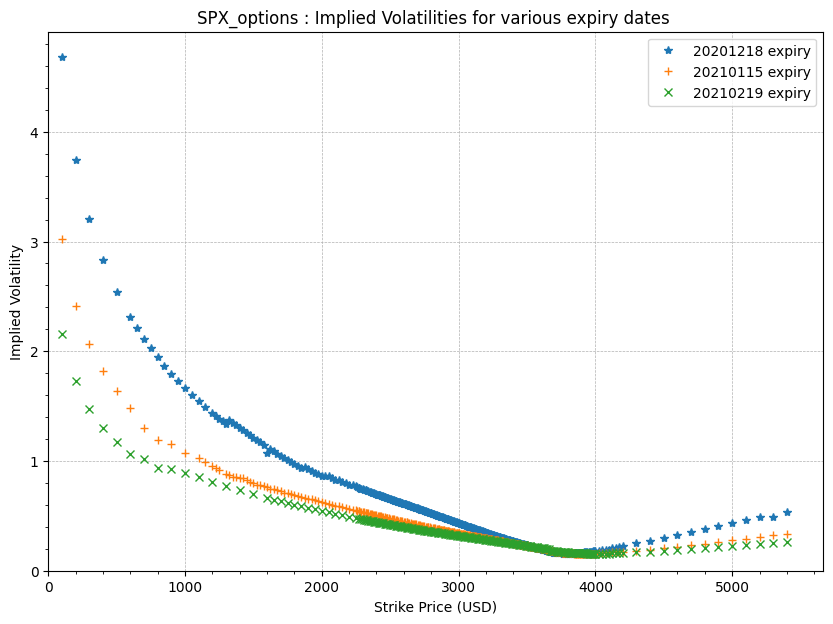

In [31]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f0, ax0 = plt.subplots(1)
f0.set_figheight(7)
f0.set_figwidth(10)
ax0.plot(summary_df['strike'],summary_df[17],'*',label = '20201218 expiry')
ax0.plot(summary_df['strike'],summary_df[45],'+',label = '20210115 expiry')
ax0.plot(summary_df['strike'],summary_df[80],'x',label = '20210219 expiry')
ax0.xaxis.set_major_locator(ticker.AutoLocator())
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax0.yaxis.set_major_locator(ticker.AutoLocator())
ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax0.grid(linestyle = '--', linewidth = 0.5)
ax0.set_ylim(ymin=0)
ax0.set_xlim(xmin=0)
ax0.legend()
ax0.set_title(f'{filename} : Implied Volatilities for various expiry dates ')
ax0.set_xlabel('Strike Price (USD)')
ax0.set_ylabel('Implied Volatility')
plt.show(f0)
f0.savefig(f'{filename}_vol_all.jpeg')

In [32]:
#get atm implied vols, this is an approximation but good enough
atm_vols = []
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    atm_vols.append(np.interp(S,adjusted_summary_df.iloc[:, 0],adjusted_summary_df.iloc[:, 1]))
atm_vols

[0.17448532472572187, 0.1849096526276905, 0.19374721854522414]

In [33]:
def dd_calibration(x,S,strikes,rate,sigma,T,market_vols):
    err = 0.0 
    imp_vol_list = []
    F = S * np.exp(rate*T)

    for strike in strikes:
        #if True:
        if strike > F:
            dd_price_call   = displaced_diffusion_call(S,strike,rate,sigma,T,x[0])
            imp_vol  = implied_volatility(S,strike,rate,dd_price_call,T,'call')
        else:
            dd_price_put    = displaced_diffusion_put(S,strike,rate,sigma,T,x[0])
            imp_vol  =  implied_volatility(S,strike,rate,dd_price_put,T,'put')
        imp_vol_list.append(imp_vol)

    zipped_vols = list(zip(market_vols, imp_vol_list))
    for market_vol, dd_vol in zipped_vols:
        err += (market_vol - dd_vol) ** 2

    return err

In [34]:
sigma_beta_pair = {}
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    
    #params
    sigma = atm_vols[i]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {rate} {T}')

    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:,1].to_numpy()

    initial = 0.5
    result = least_squares(dd_calibration ,initial, args = (S,strikes,rate,sigma,T,market_vols), bounds=(0.0,1))
    beta = result.x[0]
    sigma_beta_pair[days] = {'sigma' : sigma, 'beta' : beta}        

3662.45 3662.664084743022 0.17448532472572187 0.0012550044444444445 0.04657534246575343
3662.45 3663.3762493669747 0.1849096526276905 0.0020510755555555554 0.1232876712328767
3662.45 3664.221472703759 0.19374721854522414 0.0022062799999999997 0.2191780821917808


In [38]:
dd_summary_df = pd.DataFrame({'strike': df['strike'].unique() })
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    #params
    #sigma = 0.53827373
    sigma = sigma_beta_pair[days]['sigma']
    #beta =  1 
    beta =  sigma_beta_pair[days]['beta']
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {beta} {rate} {T}')
    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    dd_price = []
    dd_impl_vol = []
    for strike in strikes :
        #if True:
        if strike > F  :
            dd_price_call   = displaced_diffusion_call(F,strike,rate,sigma,T,beta)
            dd_vol_call = implied_volatility(S,strike,rate,dd_price_call,T,'call')
            print(f'strike {strike} days {days} call price : {dd_price_call} & vol : {dd_vol_call}')
            dd_impl_vol.append(dd_vol_call)
        else:
            dd_price_put    = displaced_diffusion_put(F,strike,rate,sigma,T,beta)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_put,T,'put'))
    day_dd_imp_df = pd.DataFrame({'strike': strikes, days : dd_impl_vol})
    dd_summary_df = pd.merge(dd_summary_df, day_dd_imp_df, how="outer", on='strike')    
    dd_summary_df = dd_summary_df.sort_values(by=['strike'])
    dd_summary_df = dd_summary_df.reset_index()
    dd_summary_df = dd_summary_df.drop(columns=['index'])
    dd_summary_df.to_csv(f'{filename}_DD_vol_summary.csv')
    dd_summary_df


3662.45 3662.664084743022 0.17448532472572187 2.8614115061353138e-06 0.0012550044444444445 0.04657534246575343
strike 3665.0 days 17 call price : 53.9686411160105 & vol : 0.17478529628086759
strike 3670.0 days 17 call price : 51.53560681903813 & vol : 0.17465675923692478
strike 3675.0 days 17 call price : 49.17477289151127 & vol : 0.17452886043522653
strike 3680.0 days 17 call price : 46.88595683467539 & vol : 0.17440157529190795
strike 3685.0 days 17 call price : 44.66888269515575 & vol : 0.1742748820003708
strike 3690.0 days 17 call price : 42.523181303362044 & vol : 0.1741487587329882
strike 3695.0 days 17 call price : 40.44839259793367 & vol : 0.17402318635620262
strike 3700.0 days 17 call price : 38.443966758161764 & vol : 0.17389814622469876
strike 3705.0 days 17 call price : 36.50926646883335 & vol : 0.173773620506251
strike 3710.0 days 17 call price : 34.64356966188473 & vol : 0.1736495930389903
strike 3715.0 days 17 call price : 32.846072198453705 & vol : 0.17352604900612165
s

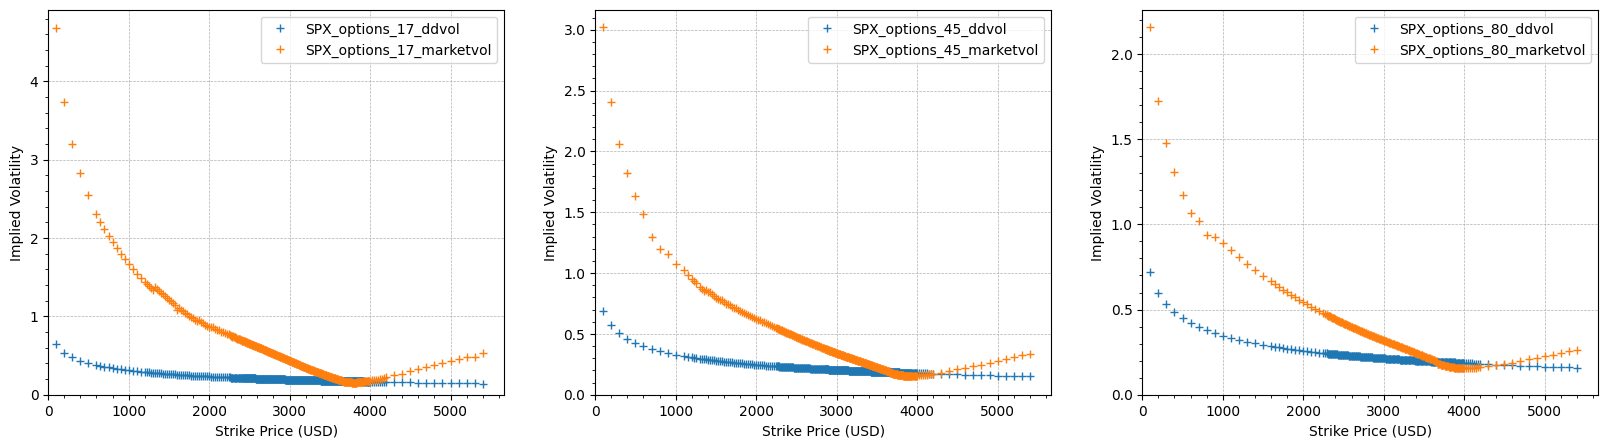

In [39]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f1, ax1 = plt.subplots(1, 3)
f1.set_figheight(5)
f1.set_figwidth(20)
for i,days in enumerate(days_to_expiry):
    ax1[i].plot(summary_df['strike'], dd_summary_df.iloc[:, 1+i],'+',label = f'{filename}_{days}_ddvol')
    ax1[i].plot(summary_df['strike'], summary_df.iloc[:, 1+i],'+',label = f'{filename}_{days}_marketvol')
    ax1[i].legend()
    ax1[i].xaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].yaxis.set_major_locator(ticker.AutoLocator())
    ax1[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1[i].grid(linestyle = '--', linewidth = 0.5)
    ax1[i].set_ylim(ymin=0)
    ax1[i].set_xlim(xmin=0)
    ax1[i].set_xlabel('Strike Price (USD)')
    ax1[i].set_ylabel('Implied Volatility')
plt.show(f1)


In [37]:
# what if we work on premise that beta is 1 and try to find sigma?
# this will require using a new 